In [ ]:
#default_exp audio.augment
#default_cls_lvl 3

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data Augmentation for Audio

> Transforms to apply data augmentation to AudioSpectrograms and Signals

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
# export
import torch.nn
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli
from librosa.effects import split
from dataclasses import asdict
from scipy.signal import resample_poly
from scipy.ndimage.interpolation import shift
import librosa
import colorednoise as cn

In [ ]:
p = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'
x = AudioGetter("", recurse=True, folders=None)
files = x(p)

In [ ]:
#files will load differently on different machines so we specify examples by name
ex_files = [p/f for f in ['m0005_us_m0005_00218.wav', 
                                'f0003_us_f0003_00279.wav', 
                                'f0001_us_f0001_00168.wav', 
                                'f0005_us_f0005_00286.wav',]]

In [ ]:
audio_orig = AudioItem.create(ex_files[0])

In [ ]:
a2s = AudioToSpec(n_fft = 1024, hop_length=256)

<class 'local.audio.core.AudioSpectrogram'>


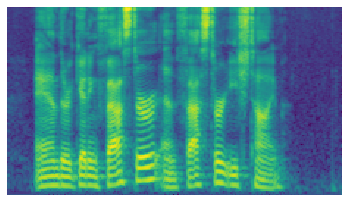

In [ ]:
#sg = spectrogram
sg_orig = a2s(audio_orig)
print(type(sg_orig))
sg_orig.show()
test_eq(sg_orig.n_fft, 1024)

In [ ]:
#get 3 equal length portions of 3 different signals so we can stack them
#for a fake multichannel example
ai0, ai1, ai2 = map(AudioItem.create, ex_files[1:4]);
min_samples = min(ai0.nsamples, ai1.nsamples, ai2.nsamples)
s0, s1, s2 = map(lambda x: x[:,:min_samples], (ai0.sig, ai1.sig, ai2.sig))
fake_multichannel = AudioItem((torch.stack((s0, s1, s2), dim=1).squeeze(0), 16000, None))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


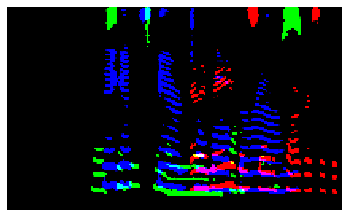

In [ ]:
sg_multi = a2s(fake_multichannel)
sg_multi.show()

# Preprocessing functions

##  Remove Silence

In [ ]:
#export
def _merge_splits(splits, pad):
    clip_end = splits[-1][1]
    merged = []
    i=0
    while i < len(splits):
        start = splits[i][0]
        while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
            i += 1
        end = splits[i][1]
        merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
        i+=1
    return np.stack(merged)

def RemoveSilence(remove_type, threshold=20, pad_ms=20):
    def _inner(ai:AudioItem)->AudioItem:
        '''Split signal at points of silence greater than 2*pad_ms '''
        if remove_type is None: return ai
        padding = int(pad_ms/1000*ai.sr)
        if(padding > ai.nsamples): return ai
        actual = ai.sig.clone()
        splits = split(actual.numpy(), top_db=threshold, hop_length=padding)
        if remove_type == "split":
            sig =  [actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                    for (a, b) in _merge_splits(splits, padding)]
        elif remove_type == "trim":
            sig = [actual[:,(max(splits[0, 0]-padding,0)):splits[-1, -1]+padding]]
        elif remove_type == "all":
            sig = [torch.cat([actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                              for (a, b) in _merge_splits(splits, padding)], dim=1)]
        else: 
            raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not '{cfg.remove_silence}'.")
        return AudioItem((*sig, ai.sr, ai.path))
    return _inner

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br/>
    1. Add in longer clips (whale) and do more extensive testing<br/></div>


File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


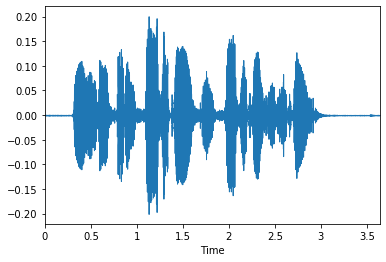

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


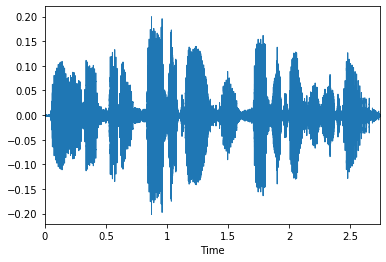

In [ ]:
silence_audio = RemoveSilence("trim", threshold=20, pad_ms=20)(audio_orig)
audio_orig.show()
silence_audio.show()
#test that at least a half second of silence is being removed
test(silence_audio.nsamples + 8000, audio_orig.nsamples, operator.le)

In [ ]:
#test that nothing is removed from audio that doesnt contain silence
test_aud = AudioItem((torch.rand_like(audio_orig.sig), 16000, None))
print("Random Noise, no silence")
test_aud.hear()
for rm_type in ["trim", "all", "split"]:
    silence_audio_trim = RemoveSilence(rm_type, threshold=20, pad_ms=20)(test_aud)
    test_eq(test_aud.nsamples, silence_audio_trim.nsamples)

Random Noise, no silence


In [ ]:
silence_audio = RemoveSilence("trim", threshold=20, pad_ms=20)(fake_multichannel)
fake_multichannel.hear()
silence_audio.hear()

CPU times: user 296 ms, sys: 28 ms, total: 324 ms
Wall time: 81.4 ms


## Resampling

In [ ]:
#export
def Resample(sr_new):
    def _inner(ai:AudioItem)->AudioItem:
        '''Resample using faster polyphase technique and avoiding FFT computation'''
        if(ai.sr == sr_new): return AudioItem(ai)
        sig_np = ai.sig.numpy()
        sr_gcd = math.gcd(ai.sr, sr_new)
        resampled = resample_poly(sig_np, int(sr_new/sr_gcd), int(ai.sr/sr_gcd), axis=-1)
        resampled = resampled.astype(np.float32)
        return AudioItem((torch.from_numpy(resampled), sr_new, ai.path))
    return _inner

In [ ]:
#Make sure if old and new sample rates are the same, a new identical AudioItem is returned
no_resample_needed = Resample(audio_orig.sr)(audio_orig)
assert(not no_resample_needed is audio_orig)
test_eq(audio_orig.sr, no_resample_needed.sr)
test_eq(audio_orig.sig, no_resample_needed.sig)

In [ ]:
#test and hear realistic sample rates
print("Original, Sample Rate", audio_orig.sr)
audio_orig.hear()
for rate in [4000,8000,22050,44100]:
    resampled = Resample(rate)(audio_orig)
    orig_samples = audio_orig.nsamples
    re_samples = resampled.nsamples
    print("Sample Rate", rate)
    resampled.hear()
    test_eq(re_samples, orig_samples//(audio_orig.sr/rate))

Original, Sample Rate 16000


Sample Rate 4000


Sample Rate 8000


Sample Rate 22050


Sample Rate 44100


In [ ]:
%%time
# polyphase does bad with random resample rates ~74ms per, but this
# should never happen because of relatively fixed sample rates
# bad == low gcd between old and new sample rate
for i in range(100):
    random_sr = random.randint(16000, 72000)
    random_upsample = Resample(random_sr)(audio_orig)
    num_samples = random_upsample.nsamples
    test_close(num_samples, abs(orig_samples//(audio_orig.sr/random_sr)), eps=1.1)

CPU times: user 31.1 s, sys: 1.2 s, total: 32.3 s
Wall time: 8.07 s


# Signal Transforms

## Signal Cropping/Padding

<div class = "alert alert-block alert-info"> CropSignal and CropTime can either be merged into one function, or they can outsource the bulk of their behavior to a shared cropping function</div>

In [ ]:
#export
def CropSignal(duration, pad_mode="zeros"):
    def _inner(ai: AudioItem)->AudioItem:
        '''Crops signal to be length specified in ms by duration, padding if needed'''
        sig = ai.sig.clone()
        orig_samples = ai.nsamples
        crop_samples = int((duration/1000)*ai.sr)
        if orig_samples < crop_samples: 
            sig_pad = _tfm_pad_signal(sig, crop_samples, pad_mode=pad_mode)
            return AudioItem((sig_pad, ai.sr, ai.path))
        elif orig_samples == crop_samples: return AudioItem((sig, ai.sr, ai.path))
        else:
            crop_start = random.randint(0, int(orig_samples-crop_samples))
            sig_crop = sig[:,crop_start:crop_start+crop_samples]
            return AudioItem((sig_crop, ai.sr, ai.path))
    return _inner

In [ ]:
#export
def _tfm_pad_signal(sig, width, pad_mode="zeros"):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,x = sig.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros-after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c, zeros_front))
        pad_back = torch.zeros((c, width-x-zeros_front))
        return torch.cat((pad_front, sig, pad_back), 1)
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sig.repeat(1,repeats)[:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros-after', or 'repeat'")

In [ ]:
cropsig_1000ms = CropSignal(1000)
cropsig_2000ms = CropSignal(2000)
cropsig_5000ms = CropSignal(5000, pad_mode="zeros-after")
print(f"Audio is {audio_orig.duration} seconds")

Audio is 3.64 seconds


In [ ]:
aud1s = cropsig_1000ms(audio_orig)
aud2s = cropsig_2000ms(audio_orig)
aud5s = cropsig_5000ms(audio_orig)

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


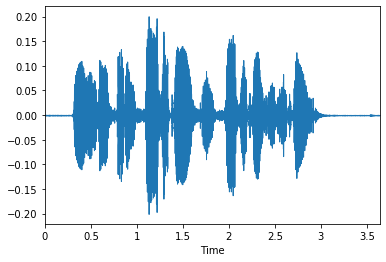

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


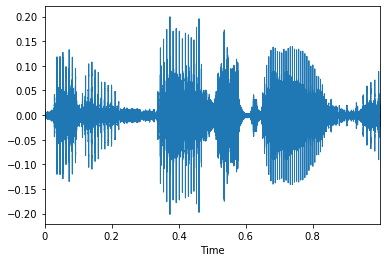

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


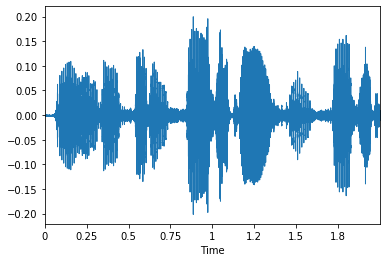

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


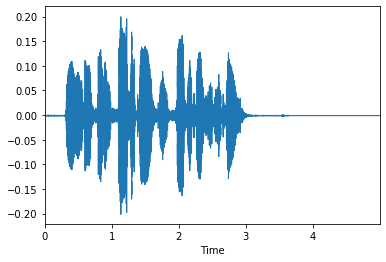

In [ ]:
audio_orig.show()
aud1s.show()
aud2s.show()
aud5s.show()

In [ ]:
test_eq(aud1s.nsamples, 1*audio_orig.sr)
test_eq(aud2s.nsamples, 2*audio_orig.sr)
test_eq(aud5s.nsamples, 5*audio_orig.sr)
test_eq(aud1s.duration, 1)
test_eq(aud2s.duration, 2)
test_eq(aud5s.duration, 5)

### Test Signal Padding Modes

In [ ]:
# test pad_mode zeros-after
test_aud = AudioItem((torch.rand_like(audio_orig.sig), 16000, None))
cropsig_pad = CropSignal(5000, pad_mode="zeros-after")
z_after = cropsig_pad(test_aud)
test_aud.hear()
z_after.hear()
# test end of signal is padded with zeros
test_eq(z_after.sig[:,-10:], torch.zeros_like(z_after.sig)[:,-10:])
# test front of signal is not padded with zeros
test_ne(z_after.sig[:,0:10] , z_after.sig[:,-10:])

In [ ]:
# test pad_mode zeros by verifying signal begins and ends with zeros
test_aud.hear()
cropsig_pad = CropSignal(5000, pad_mode="zeros")
z_after = cropsig_pad(test_aud)
z_after.hear()
test_eq(z_after.sig[:,0:2], z_after.sig[:,-2:])

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


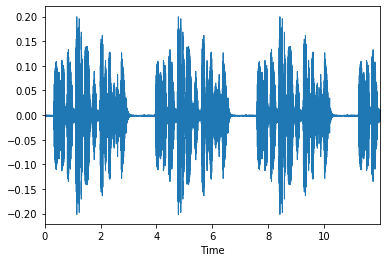

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
cropsig_repeat = CropSignal(12000, pad_mode="repeat")
ai_repeat = cropsig_repeat(audio_orig)
ai_repeat.show()
sig_repeat = ai_repeat.sig
for i in range(audio_orig.nsamples):
    test_eq(sig_repeat[:,i], sig_repeat[:,i+audio_orig.nsamples])
    test_eq(sig_repeat[:,i], sig_repeat[:,i+2*audio_orig.nsamples])

In [ ]:
# test bad pad_mode doesnt fail silently
test_fail(CropSignal(12000, pad_mode="tenchify"))

## Shift signal

In [ ]:
def ShiftSignal(max_pct=0.2, max_time=None, roll=False):
    def _inner(ai: AudioItem)->AudioItem:
        d = random.uniform(-1, 1)*max_pct*ai.nsamples if max_time is None else random.uniform(-1, 1)*max_time*ai.sr
        sig = np.roll(ai.sig.numpy(), int(d), axis=1) if roll else shift(ai.sig.numpy(), [0, d]) 
        return AudioItem((torch.tensor(sig), ai.sr, ai.path))
    return _inner

### Example without rolling

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


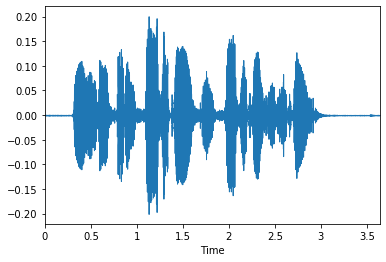

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


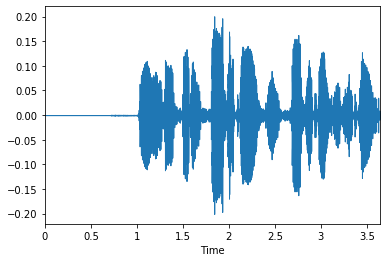

In [ ]:
shifter = ShiftSignal(0.2)
shifted = shifter(audio_orig)
audio_orig.show()
shifted.show()
test_eq(audio_orig.sig.shape, shifted.sig.shape)

In [ ]:
# test a time shift of 1s never shifts more than 1s
for i in range(100):
    time_shifter = ShiftSignal(max_time=1)
    just_ones = AudioItem((torch.ones(16000).unsqueeze(0), 16000, None))
    shifted = time_shifter(just_ones)
    test_eq(False, torch.allclose(shifted.sig, torch.zeros(16000)))

### Example with rolling

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


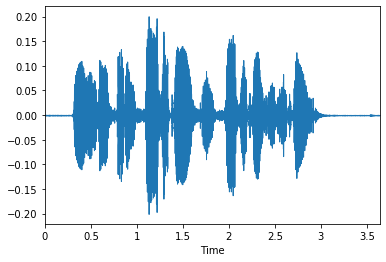

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


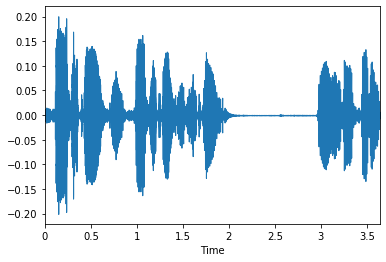

In [ ]:
shifter = ShiftSignal(0.4, roll=True)
shifted = shifter(audio_orig)
audio_orig.show()
shifted.show()
test_eq(audio_orig.sig.shape, shifted.sig.shape)

## Add noise to signal

Adds noise proportional to the energy of the signal (mean of abs value), and the specified noise level.

This uses [colorednoise](https://github.com/felixpatzelt/colorednoise)(imported as 'cn'), developed by a data scientist named [Felix Patzelt](https://github.com/felixpatzelt). It allows you to use one simple function to create white, brown, pink and other [colors of noise](https://en.wikipedia.org/wiki/Colors_of_noise). Each color corresponds to an exponent, violet is -2, blue -1, white is 0, pink is 1, and brown is 2. We abstract this with a class that enumerates the list and shifts it down two so the exponents are correct, and so that we get tab-completion.



For just plain white noise, if we revert to remove the dependency on this library, the noise can be created with  
`noise = torch.randn_like(ai.sig) * ai.sig.abs().mean() * noise_level`

In [ ]:
# export
mk_class('NoiseColor', **{o:i-2 for i,o in enumerate(['Violet', 'Blue', 'White', 'Pink', 'Brown'])},
         doc="All possible colors of noise as attributes to get tab-completion and typo-proofing")

### 

In [ ]:
def AddNoise(noise_level=0.05, color=NoiseColor.White):
    def _inner(ai: AudioItem)->AudioItem:
        noise = cn.powerlaw_psd_gaussian(exponent=color, size=ai.nsamples)
        tnoise = torch.from_numpy(noise).float()
        scaled_noise = tnoise * ai.sig.abs().mean() * noise_level
        return AudioItem((ai.sig + scaled_noise, ai.sr, ai.path))
    return _inner

### White noise examples (default)

Original Audio
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


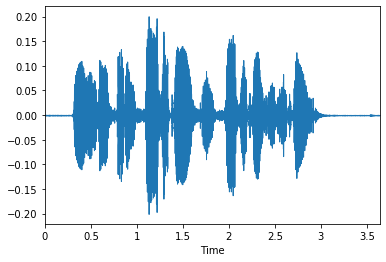

5% White Noise
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


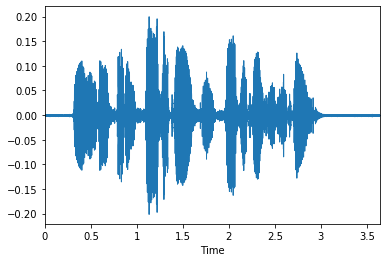

50% White Noise
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


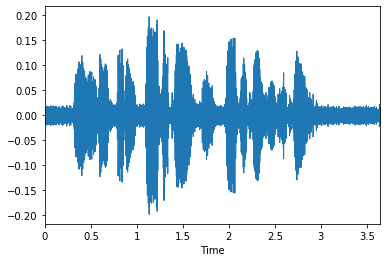

In [ ]:
noisy = AddNoise()(audio_orig)
real_noisy = AddNoise(0.5)(audio_orig)
msgs = ["Original Audio", "5% White Noise", "50% White Noise"]
for i, aud in enumerate([audio_orig, noisy, real_noisy]):
    print(msgs[i])
    aud.show()

Original Audio
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


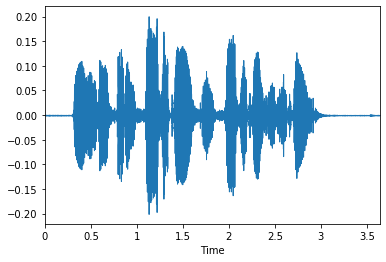

5% Pink Noise
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


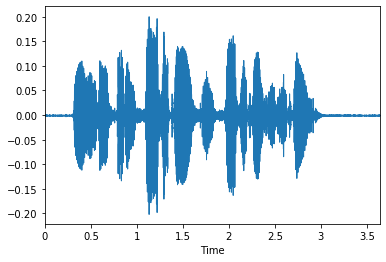

100% Pink Noise
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


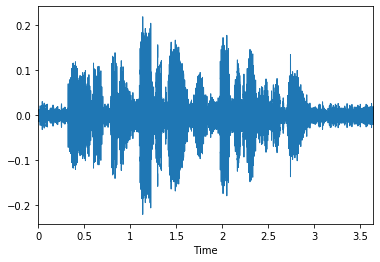

In [ ]:
noisy = AddNoise(color=NoiseColor.Pink)(audio_orig)
real_noisy = AddNoise(1, color=NoiseColor.Pink)(audio_orig)
msgs = ["Original Audio", "5% Pink Noise", "100% Pink Noise"]
for i, aud in enumerate([audio_orig, noisy, real_noisy]):
    print(msgs[i])
    aud.show()

## Adjust Volume

<div class = "alert alert-block alert-warning"><strong>Note:</strong><br> 
   This will increase/decrease the energy of the signal but so far it appears to do nothing besides change the absolute values as the audios sound the same, and the spectrograms appear the same. The gain is being correctly applied, but the ipython audio player seems to normalize the volume level (confirmed by outputting and downloading the clips and confirming a difference in noise level). The spectrogram appears the same because it too does a form of normalization when it sets `ref`. We will likely need to adjust the ref value to something constant like np.max or 0 to stop this normalization, as the noise_level is often relevant for deep learning and not something we want to strip out.<br></div>


In [ ]:
def ChangeVolume(lower=0.1, upper=1.2):
    def _inner(ai: AudioItem)->AudioItem:
        gain = random.uniform(lower, upper)
        return AudioItem((gain*factor, ai.sr, ai.path))
    return _inner

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


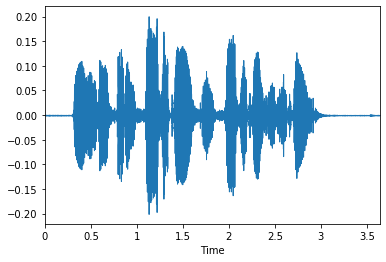

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


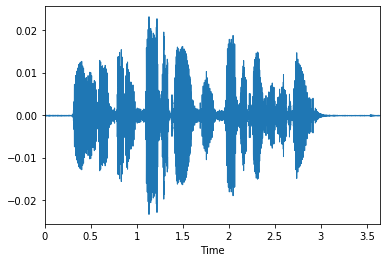

In [ ]:
#ipython player normalizes out volume difference, note different y-axis scale but same sound.
altered = ChangeVolume(lower=0.1, upper=0.2)(audio_orig)
audio_orig.show()
altered.show()

## Signal Cutout

In [ ]:
def Cutout(cut_pct=0.15):
    def _inner(ai: AudioItem)->AudioItem:
        copy = ai.sig.clone()
        mask = torch.zeros(int(ai.nsamples*cut_pct))
        mask_start = random.randint(0,ai.nsamples-len(mask))
        copy[:,mask_start:mask_start+len(mask)] = mask
        return AudioItem((copy, ai.sr, ai.path))
    return _inner

In [ ]:
cut = Cutout()(audio_orig)

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


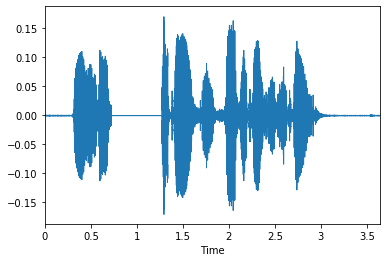

In [ ]:
cut.show()

## Signal Loss 

In [ ]:
#Code taken from orig v1 fastai audio by Zack Caceres, Thom Mackey, and Stefano Giomo
def SignalDrop(cut_pct=0.15):
    def _inner(ai: AudioItem)->AudioItem:
        """Randomly replaces amplitude of signal with 0. Simulates analog info loss"""
        copy = ai.sig.clone()
        mask = (torch.rand_like(copy)>cut_pct).float()
        masked = copy * mask
        return AudioItem((masked, ai.sr, ai.path))
    return _inner

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


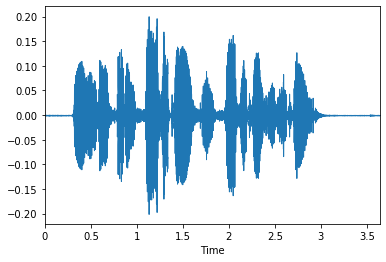

In [ ]:
dropped = DropSignal()(audio_orig)
dropped.show()

## DownmixMono

In [ ]:
# downmixMono was removed from torchaudio, we now just take the mean across channels
# this should work for both batches and individual items
def DownmixMono():
    def _inner(ai: AudioItem)->AudioItem:
        """Randomly replaces amplitude of signal with 0. Simulates analog info loss"""
        print(ai.sig.shape)
        downmixed = ai.sig.contiguous().mean(-2).unsqueeze(-2)
        print(downmixed.shape)
        return AudioItem((downmixed, ai.sr, ai.path))
    return _inner

torch.Size([3, 53760])
torch.Size([1, 53760])
File: None


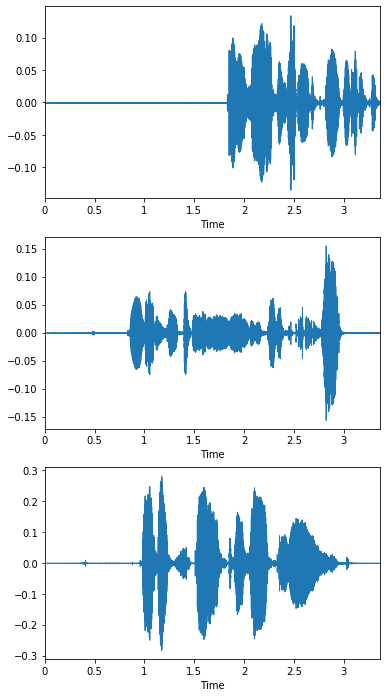

File: None


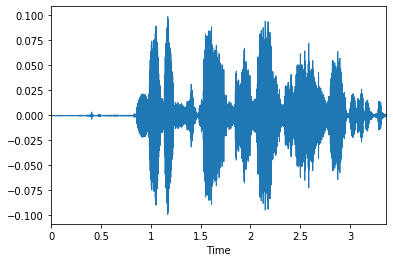

In [ ]:
downmixed = DownmixMono()(fake_multichannel)
fake_multichannel.show()
downmixed.show()

In [ ]:
# example showing a batch of 4 signals 
f2 = fake_multichannel.sig.unsqueeze(0)
fake_batch = torch.cat([f2,f2,f2,f2], dim=0)
downmixed = fake_batch.contiguous().mean(-2).unsqueeze(-2)
print("Before shape:", fake_batch.shape)
print("After shape:", downmixed.shape)

Before shape: torch.Size([4, 3, 53760])
After shape: torch.Size([4, 1, 53760])


# Spectrogram Transforms

##  CropTime, pad_spectro(internal)

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br> 
   1. In spectrogram when we pad with mean value we mess up normalization by altering std dev, how can we use fill values that dont mess things up<br></div>


In [ ]:
#export
def CropTime(duration, pad_mode="zeros"):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Random crops full spectrogram to be length specified in ms by crop_duration'''
        sg = spectro.clone()
        sr, hop = spectro.sr, spectro.hop_length
        w_crop = int((sr*duration)/(1000*hop))+1
        w_sg   = sg.shape[-1]
        if   w_sg <  w_crop: 
            sg_pad = _tfm_pad_spectro(sg, w_crop, pad_mode=pad_mode)
            return AudioSpectrogram.create(sg_pad, settings=spectro.settings)
        elif w_sg == w_crop: return sg
        else:
            crop_start = random.randint(0, int(w_sg - w_crop))
            sg_crop = sg[:,:,crop_start:crop_start+w_crop]
            sg_crop.sample_start = int(crop_start*hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(duration*sr)
            return AudioSpectrogram.create(sg_crop, settings=spectro.settings)
    return _inner

In [ ]:
#export
def _tfm_pad_spectro(sg, width, pad_mode="zeros"):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,y,x = sg.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros-after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c,y, zeros_front))
        pad_back = torch.zeros((c,y, width-x-zeros_front))
        return AudioSpectrogram(torch.cat((pad_front, sg, pad_back), 2))
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sg.repeat(1,1,repeats)[:,:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros-after', or 'repeat'")

In [ ]:
crop_1000ms = CropTime(1000)
crop_2000ms = CropTime(2000)
crop_5000ms = CropTime(5000)
print(f"Audio is {audio_orig.duration} seconds")

Audio is 3.64 seconds


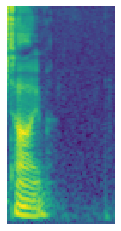

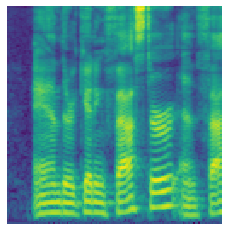

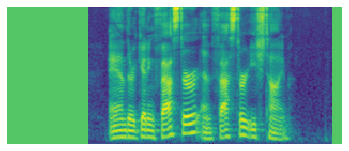

In [ ]:
s1 = crop_1000ms(sg_orig)
s1.show()
s2 = crop_2000ms(sg_orig)
s2.show()
s5 = crop_5000ms(sg_orig)
s5.show()

<div class = "alert alert-block alert-info"><strong>Note:</strong><br> 
    Because a spectrograms duration is dependent on rounding (samples/hop_length usually has a remainder that is padded up to an extra pixel), we cant use exact durations, so we must test_close instead of test_eq. This could be fixed by storing the AudioItems duration when the sg is generated, and also updating the duration manually anytime a Transform occurs that affects the size time axis (x-axis)
</div>


In [ ]:
test_eq(sg_orig.settings, s1.settings)
test_eq(sg_orig.settings, s5.settings)
test_close(s1.width, int((1/sg_orig.duration)*sg_orig.width), eps=1.01)
test_close(s2.width, int((2/sg_orig.duration)*sg_orig.width), eps=1.01)
test_close(s5.width, int((5/sg_orig.duration)*sg_orig.width), eps=1.01)

In [ ]:
# test AudioToSpec->CropTime and CropSignal->AudioToSpec will result in same size images
oa = OpenAudio(files)
crop_dur = random.randint(1000,5000)
pipe_cropsig  = Pipeline([oa, AudioToSpec(hop_length=128), CropTime(crop_dur)], as_item=True)
pipe_cropspec = Pipeline([oa, CropSignal(crop_dur), AudioToSpec(hop_length=128), ], as_item=True)
for i in range(50):
    test_eq(pipe_cropsig(i).width, pipe_cropspec(i).width)

In [ ]:
# test pad_mode zeros-after by verifying sg ends with zeros and begins with non-zeros
crop_5000ms = CropTime(5000, pad_mode="zeros-after")
s5 = crop_5000ms(sg_orig)
test_eq(s5[:,:,-1], torch.zeros_like(s5)[:,:,-1])
test_ne(s5[:,:,0], torch.zeros_like(s5)[:,:,-1])

In [ ]:
sg_orig.duration

3.64

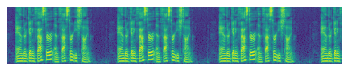

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
crop_12000ms = CropTime(12000, pad_mode="repeat")
s12_repeat = crop_12000ms(sg_orig)
s12_repeat.show()
for i in range(sg_orig.width):
    test_eq(s12_repeat[:,:,i], s12_repeat[:,:,i+sg_orig.width])
    test_eq(s12_repeat[:,:,i], s12_repeat[:,:,i+2*sg_orig.width])

In [ ]:
# test bad pad_mode doesnt fail silently
test_fail(CropTime(12000, pad_mode="zerosafter"))

In [ ]:
s1.shape, s2.shape, s5.shape

(torch.Size([1, 128, 63]),
 torch.Size([1, 128, 126]),
 torch.Size([1, 128, 313]))

<div class = "alert alert-block alert-info"> If we wanted to we could make a class for these transforms that keeps the masked portion as state so that we could write a decodes method to go back to the original</div>


### SpecAugment

In [ ]:
#export
def MaskFreq(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        nonlocal start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape
        for _ in range(num_masks):
            mask = torch.ones(size, x) * mask_val    
            if start is None: start= random.randint(0, y-size)
            if not 0 <= start <= y-size:
                raise ValueError(f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,start:start+size,:] = mask
            start = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

<div class = "alert alert-block alert-warning"> Passing around the settings manually is already fairly clunky, but is especially bad when we have to do it twice when MaskTime hands off to MaskFrequency. We should maybe make a copy of the AudioSpectrogram and then alter the tensor for it's sg rather than cloning out the sg and then building a new object at the end. Or just keep a reference to the parent tensor and pass that along, and have getattr recur looking for settings of the parents</div>


In [ ]:
#export
def MaskTime(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone()
        sg = torch.einsum('...ij->...ji', sg)
        sg = AudioSpectrogram.create(sg, settings=spectro.settings)
        sg = MaskFreq(num_masks, size, start, val, **kwargs)(sg)
        return AudioSpectrogram.create(torch.einsum('...ij->...ji', sg), settings=spectro.settings)
    return _inner

In [ ]:
freq_mask = MaskFreq()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.4 ms


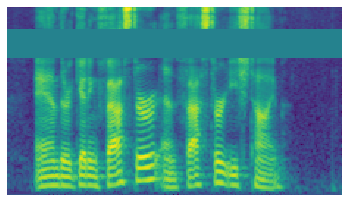

In [ ]:
%%time
freq_mask(sg_orig).show()

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 145 ms


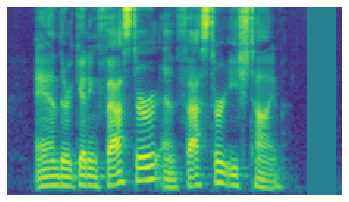

In [ ]:
%%time
time_mask = MaskTime()
time_mask(sg_orig).show()

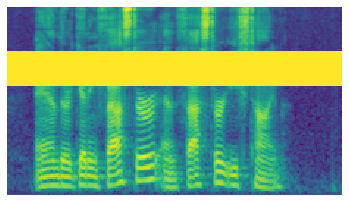

In [ ]:
# create a random frequency mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
freq_mask_test = MaskFreq(size=size, start=start, val=val)
sg_test = freq_mask_test(sg_orig)
sg_test.show()
test_eq(sg_test[:,start:start+size,:], val*torch.ones_like(sg_orig)[:,start:start+size,:])

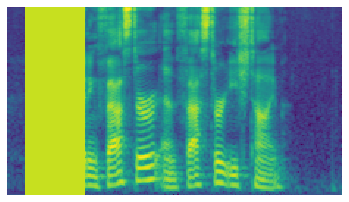

In [ ]:
# create a random time mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
time_mask_test = MaskTime(size=size, start=start, val=val)
sg_test = time_mask_test(sg_orig)
sg_test.show()
test_eq(sg_test[:,:,start:start+size], val*torch.ones_like(sg_orig)[:,:,start:start+size])

## SG Roll

In [ ]:
def TfmRoll(max_shift_pct=0.7, direction=0, **kwargs):
    '''Shifts spectrogram along x-axis wrapping around to other side'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        if len(spectro.shape) < 2:
            raise Exception('Cannot apply spectrogram rolling to a signal')
        nonlocal direction
        direction = random.choice([-1, 1]) if direction == 0 else direction
        sg = spectro.clone()
        c, height, width = sg.shape
        roll_by = int(width*random.random()*max_shift_pct*direction)
        sg = sg.roll(roll_by, dims=2)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
roller = TfmRoll()

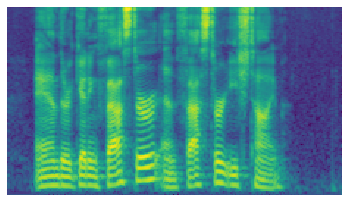

In [ ]:
sg_orig.show()

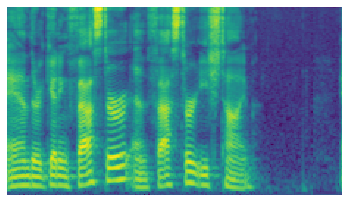

In [ ]:
roller(sg_orig).show()

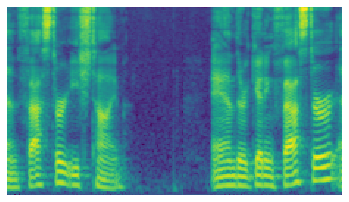

In [ ]:
roller(sg_orig).show()

In [ ]:
#fails occasionally when by chance roll is 0, but i dont want to change to >= or <= because 
#it wont detect a broken roll! Could maybe scrap this test, it's overly complex
def _first_non_zero_col(t):
    for i in range(t.shape[2]):
        if(t[0,0,i].item() == 1): return i
roll_spec = a2s(audio_orig)
mid = int((roll_spec.width/2))-5
test_spec = torch.zeros_like(roll_spec)
test_spec[:,:,mid:mid+10] = 1
roll_spec.data = test_spec
left_roller = TfmRoll(max_shift_pct=0.4, direction=-1)
left_spec = left_roller(roll_spec).data
right_roller = TfmRoll(max_shift_pct=0.4, direction=1)
right_spec = right_roller(roll_spec).data
ostart, lstart, rstart = map(_first_non_zero_col, (test_spec, left_spec, right_spec))
test(lstart, ostart, operator.lt)
test(rstart, ostart, operator.gt)

## Delta/Accelerate 

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Test delta as part of a pipeline to make sure SpecAugment/roll/interpolate...etc are working on multichannel</div>


In [ ]:
#export
def _torchdelta(mel:AudioSpectrogram, order=1, width=9):
    '''Converts to numpy, takes delta and converts back to torch, needs torchification'''
    if(mel.shape[1] < width): 
        raise ValueError(f'''Delta not possible with current settings, inputs must be wider than 
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width''')
    return AudioSpectrogram(torch.from_numpy(librosa.feature.delta(mel.numpy(), order=order, width=width)))

In [ ]:
def Delta(width=9):
    td = partial(_torchdelta, width=width)
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        new_channels = [torch.stack([c, td(c, order=1), td(c, order=2)]) for c in spectro]
        return AudioSpectrogram.create(torch.cat(new_channels), settings=spectro.settings)
    return _inner

In [ ]:
delta = Delta()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape torch.Size([3, 128, 228])


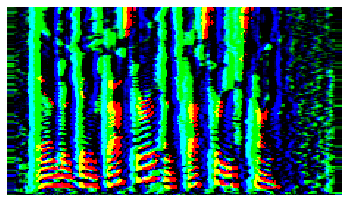

In [ ]:
d = delta(sg_orig)
print("Shape",d.shape)
d.show()
test_eq(d.nchannels, 3*sg_orig.nchannels)
test_eq(d.shape[1:], sg_orig.shape[1:])
test_ne(d[0],d[1])

## Image resizing

<div class = "alert alert-block alert-info"> This should probably be refactored to use visions size transform since it already exists</div>


In [ ]:
def TfmResize(size, interp_mode="bilinear", **kwargs):
    '''Temporary fix to allow image resizing transform'''
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        nonlocal size
        if isinstance(size, int): size = (size, size)
        sg = spectro.clone()
        c,y,x = sg.shape
        sg = F.interpolate(sg.unsqueeze(0), size=size, mode=interp_mode, align_corners=False).squeeze(0)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
# Test when size is an int
size=224
resizer = TfmResize(size)
resized = resizer(sg_orig)
print("Original Shape: ", sg_orig.shape)
print("Resized Shape :" , resized.shape)
test_eq(resized.shape[1:], torch.Size([size,size]))

Original Shape:  torch.Size([1, 128, 228])
Resized Shape : torch.Size([1, 224, 224])


Original Shape:  torch.Size([1, 128, 228])
Resized Shape : torch.Size([1, 124, 581])


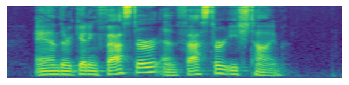

In [ ]:
# Test when size is a tuple with unequal values
size_tup=(124,581)
resizer_tup = TfmResize(size_tup)
resized_tup = resizer_tup(sg_orig)
print("Original Shape: ", sg_orig.shape)
print("Resized Shape :" , resized_tup.shape)
resized_tup.show()
test_eq(resized_tup.shape[1:], torch.Size(size_tup))

## Pipeline testing

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Allow beginner to choose height and width of output spectrogram and have settings adjust accordingly</div>


In [ ]:
files

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True (object,object) -> encodes (object,object) -> decodes

In [ ]:
sg_cfg = MelSpectrogramConfig(hop_length=256, n_fft=2048)
pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg), CropTime(1000), MaskTime(num_masks=2, size=4), MaskFreq(val=42)], as_item=True)

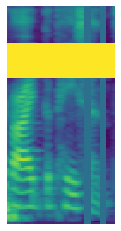

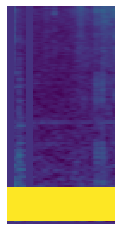

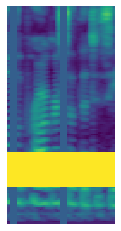

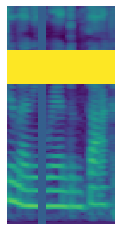

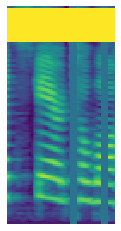

In [ ]:
for i in range(5): pipe.show(pipe(i))

# Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_utils.ipynb.
Converted 01b_dispatch.ipynb.
Converted 01c_transform.ipynb.
Converted 02_script.ipynb.
Converted 03_torch_core.ipynb.
Converted 03a_layers.ipynb.
Converted 04_dataloader.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_data_block.ipynb.
Converted 08_vision_core.ipynb.
Converted 09_vision_augment.ipynb.
Converted 09a_vision_data.ipynb.
Converted 10_pets_tutorial.ipynb.
Converted 11_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 21_vision_learner.ipynb.
Converted 22_tutorial_imagene